<a href="https://colab.research.google.com/github/Emma-Cap/Deep-Learning-Project/blob/main/Prova%20forse%20finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import zipfile
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import math
import cv2
import numpy as np

# Specifica il percorso del file zip
zip_path = '/content/archive.zip'

# Specifica la directory dove vuoi estrarre il file zip
extract_path = '/content/dataset'

# Estrai il file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Visualizza il contenuto delle directory estratte
for root, dirs, files in os.walk(extract_path):
    print(f"In directory: {root}")
    print(f"Cartelle: {dirs}")

In directory: /content/dataset
Cartelle: ['faces_02', 'test', 'validation', 'train', 'faces']
In directory: /content/dataset/faces_02
Cartelle: ['part3']
In directory: /content/dataset/faces_02/part3
Cartelle: []
In directory: /content/dataset/test
Cartelle: []
In directory: /content/dataset/validation
Cartelle: []
In directory: /content/dataset/train
Cartelle: []
In directory: /content/dataset/faces
Cartelle: ['Train']
In directory: /content/dataset/faces/Train
Cartelle: []


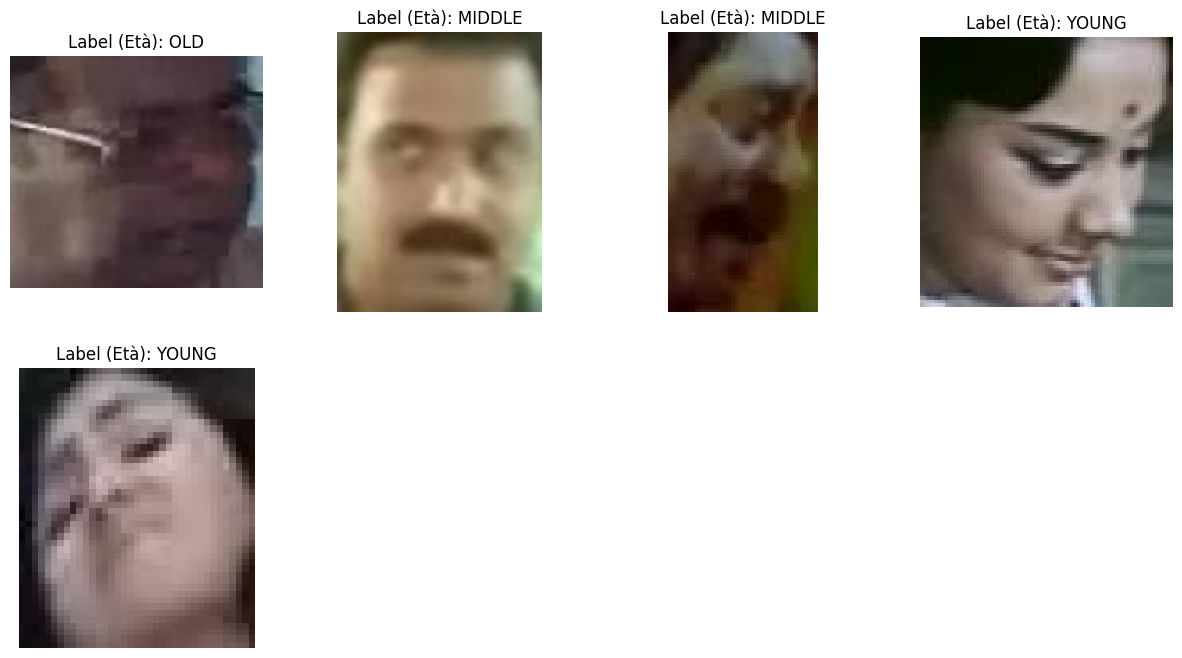

In [4]:
# Percorso del file CSV e della cartella immagini
annotations_file = '/content/dataset/faces/train.csv'
images_dir = '/content/dataset/faces/Train'

# Leggi il file CSV
annotations = pd.read_csv(annotations_file)

# Campiona casualmente 5 immagini
sample_images = annotations.sample(5)

# Configura il numero di colonne desiderato per mostrare le immagini affiancate
columns = 4

# Calcola il numero di righe necessario
rows = math.ceil(len(sample_images) / columns)

# Crea una figura e una griglia
fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 4))
axes = axes.flatten()  # Rende la griglia un array monodimensionale per iterazione semplice

# Itera sulle immagini e mostrale
for idx, (ax, (_, row)) in enumerate(zip(axes, sample_images.iterrows())):
    image_path = os.path.join(images_dir, row['ID'])  # Usa la colonna 'ID' per il nome del file
    label = row['Class']  # Usa la colonna 'Class' per la label

    # Carica e mostra l'immagine
    img = Image.open(image_path)
    ax.imshow(img)
    ax.set_title(f"Label (Età): {label}")
    ax.axis('off')

# Nascondi gli assi extra se ci sono meno immagini che celle nella griglia
for ax in axes[len(sample_images):]:
    ax.axis('off')

# Mostra la figura finale
#plt.tight_layout()
#plt.show()


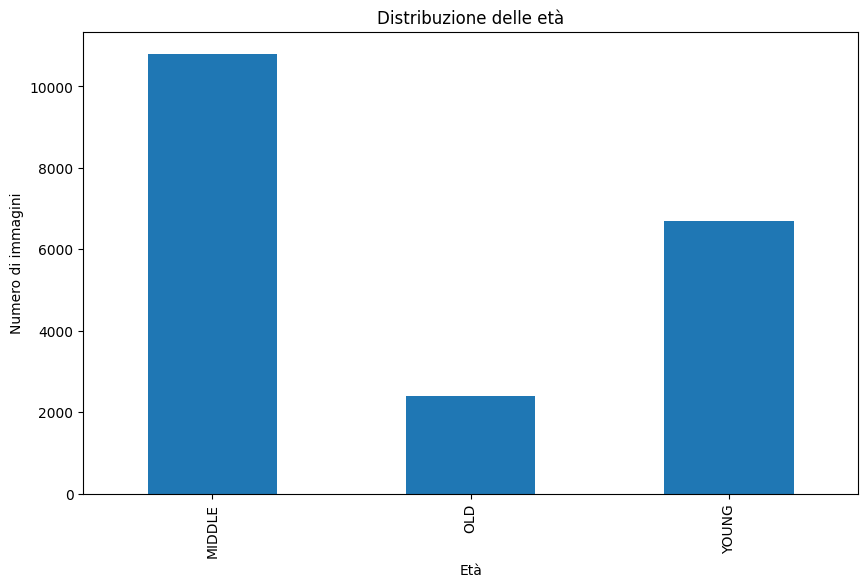

In [5]:
# Distribuzione delle età
age_distribution = annotations['Class'].value_counts().sort_index()

# Plot distribuzione
plt.figure(figsize=(10, 6))
age_distribution.plot(kind='bar')
plt.title('Distribuzione delle età')
plt.xlabel('Età')
plt.ylabel('Numero di immagini')
plt.show()

In [6]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import torchvision.transforms as transforms
from tqdm import tqdm

# Supponiamo che queste variabili esistano già
# annotations: DataFrame con ID e Class delle immagini originali
# images_dir: Directory contenente le immagini originali
# output_dir: Directory dove salveremo tutte le immagini finali
output_dir = 'final_images'
os.makedirs(output_dir, exist_ok=True)

# **1. Filtra immagini con rumore elevato**
noise_threshold = 500
high_noise_images = []

for img_name in annotations['ID']:
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        laplacian = cv2.Laplacian(img, cv2.CV_64F)
        variance = laplacian.var()
        if variance > noise_threshold:
            high_noise_images.append(img_name)

# Rimuovi le immagini rumorose dal DataFrame
high_noise_images_set = set(high_noise_images)
filtered_annotations = annotations[~annotations['ID'].isin(high_noise_images_set)]
print(f"Filtrato per rumore: {len(high_noise_images)} immagini rimosse.")

# **2. Filtra immagini a bassa risoluzione**
low_res_images_info = []
for img_name in filtered_annotations['ID']:
    img_path = os.path.join(images_dir, img_name)
    with Image.open(img_path) as img:
        width, height = img.size
        resolution = width * height
        if resolution < 10000:  # Risoluzione bassa: 100x100
            low_res_images_info.append((img_name, resolution))

# Ordina per risoluzione e rimuovi le prime 2600
low_res_images_info = sorted(low_res_images_info, key=lambda x: x[1])
images_to_remove = [img[0] for img in low_res_images_info[:2600]]
images_to_remove_set = set(images_to_remove)

filtered_annotations = filtered_annotations[~filtered_annotations['ID'].isin(images_to_remove_set)]
print(f"Filtrato per risoluzione: {len(images_to_remove)} immagini rimosse.")

# **3. Identifica immagini di alta qualità**
high_quality_images = []
for idx, row in filtered_annotations.iterrows():
    img_name = row['ID']
    img_class = row['Class']
    img_path = os.path.join(images_dir, img_name)
    with Image.open(img_path) as img:
        width, height = img.size
        if width > 224 and height > 224:  # Soglia di alta qualità
            high_quality_images.append({'ID': img_name, 'Class': img_class})

high_quality_df = pd.DataFrame(high_quality_images)
print(f"Immagini di alta qualità identificate: {len(high_quality_df)}.")

# **4. Data augmentation sulle immagini di alta qualità**
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
])

num_augmented_per_image = 5
augmented_images_list = []

for idx, row in tqdm(high_quality_df.iterrows(), total=len(high_quality_df)):
    img_name = row['ID']
    label = row['Class']
    img_path = os.path.join(images_dir, img_name)

    with Image.open(img_path) as img:
        for i in range(num_augmented_per_image):
            augmented_img = augmentation_transforms(img)
            new_img_name = f"aug_{i}_{img_name}"
            augmented_images_list.append({'ID': new_img_name, 'Class': label})

            # Salva l'immagine augmentata nella directory finale
            augmented_img.save(os.path.join(output_dir, new_img_name))

print(f"Immagini augmentate generate e salvate: {len(augmented_images_list)}")

# **5. Salva le immagini originali rimaste dopo i filtraggi**
for idx, row in filtered_annotations.iterrows():
    img_name = row['ID']
    img_path = os.path.join(images_dir, img_name)
    output_path = os.path.join(output_dir, img_name)
    with Image.open(img_path) as img:
        img.save(output_path)  # Salva le immagini rimaste nella directory finale

print(f"Immagini originali filtrate e salvate: {len(filtered_annotations)}")

# **6. Combina dataset originale e augmentato**
augmented_labels_df = pd.DataFrame(augmented_images_list)
final_annotations = pd.concat([filtered_annotations, augmented_labels_df], ignore_index=True)
print(f"Dataset finale: {final_annotations.shape[0]} immagini totali.")

# **7. Salva il DataFrame finale delle annotazioni**
final_annotations.to_csv(os.path.join(output_dir, 'final_annotations.csv'), index=False)
print(f"Annotazioni finali salvate in: {os.path.join(output_dir, 'final_annotations.csv')}")

Filtrato per rumore: 3074 immagini rimosse.
Filtrato per risoluzione: 2600 immagini rimosse.
Immagini di alta qualità identificate: 1532.


100%|██████████| 1532/1532 [02:15<00:00, 11.32it/s]


Immagini augmentate generate e salvate: 7660
Immagini originali filtrate e salvate: 14232
Dataset finale: 21892 immagini totali.
Annotazioni finali salvate in: final_images/final_annotations.csv


<ipython-input-7-203543204c95>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-7-203543204c95>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


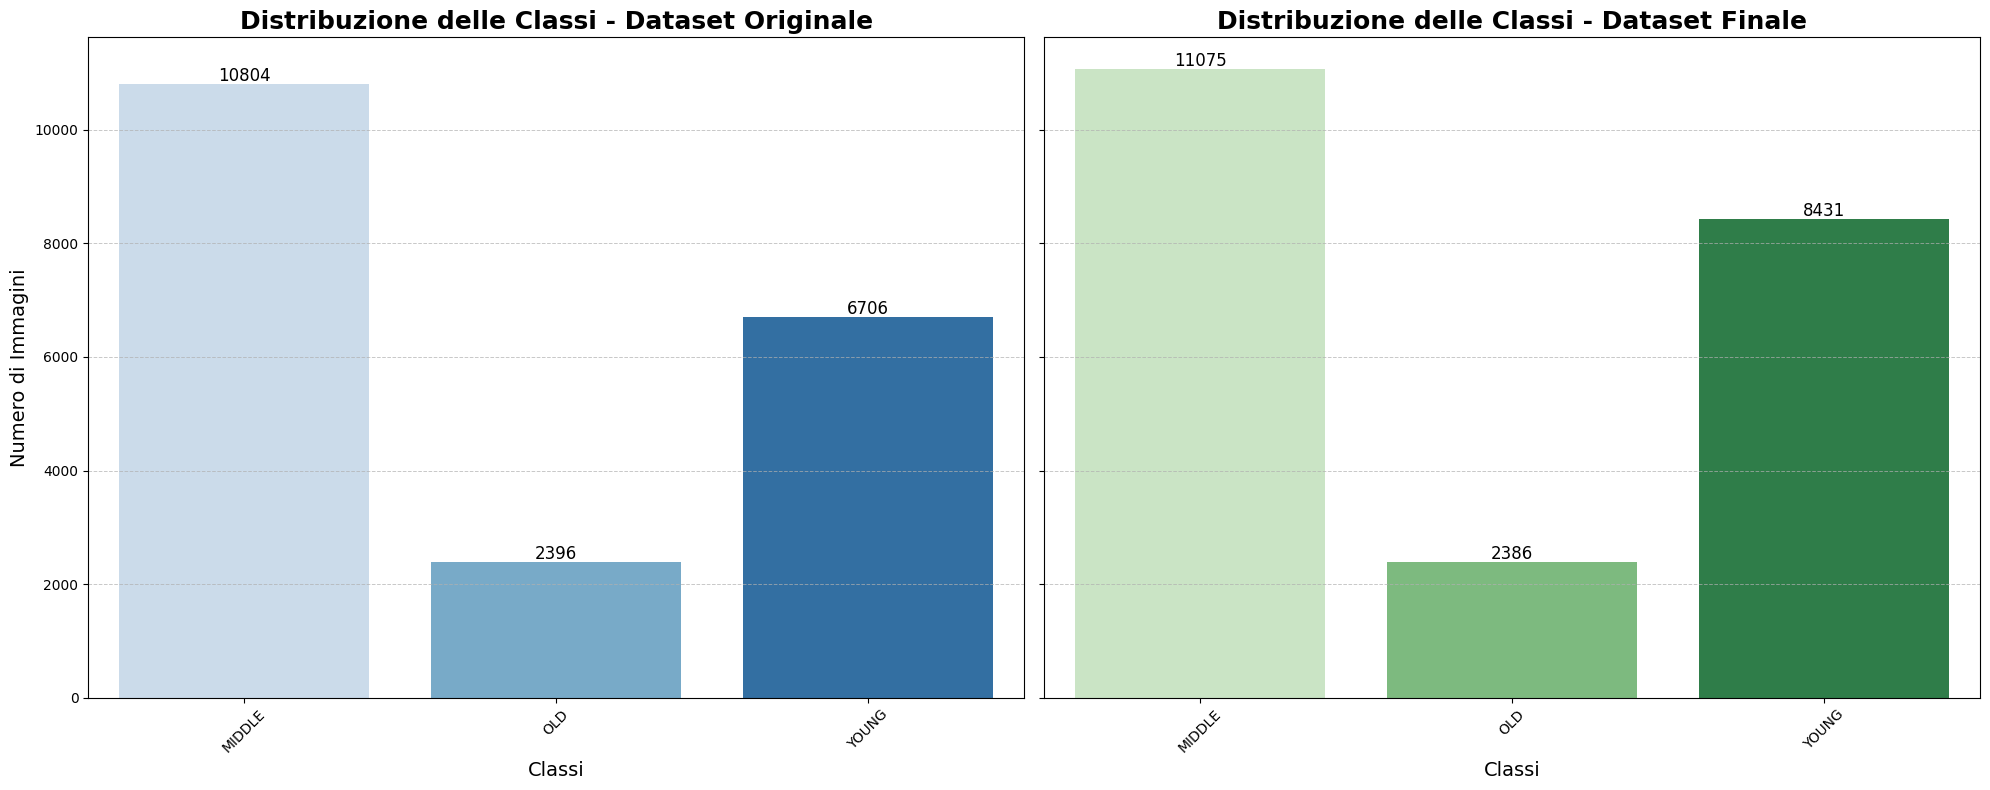

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Genera la distribuzione delle classi per dataset originale e finale
class_distribution_original = annotations['Class'].value_counts().sort_index()
class_distribution_final = final_annotations['Class'].value_counts().sort_index()

# Crea una figura con due subplot affiancati per il confronto
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Colori per i plot
palette_original = sns.color_palette("Blues", len(class_distribution_original))
palette_final = sns.color_palette("Greens", len(class_distribution_final))

# Plot per il dataset originale
sns.barplot(
    x=class_distribution_original.index,
    y=class_distribution_original.values,
    palette=palette_original,
    ax=axes[0]
)
axes[0].set_title('Distribuzione delle Classi - Dataset Originale', fontsize=18, fontweight='bold')
axes[0].set_xlabel('Classi', fontsize=14)
axes[0].set_ylabel('Numero di Immagini', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_original.values):
    axes[0].text(i, value + 50, str(value), ha='center', fontsize=12, color='black')

# Plot per il dataset finale
sns.barplot(
    x=class_distribution_final.index,
    y=class_distribution_final.values,
    palette=palette_final,
    ax=axes[1]
)
axes[1].set_title('Distribuzione delle Classi - Dataset Finale', fontsize=18, fontweight='bold')
axes[1].set_xlabel('Classi', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_final.values):
    axes[1].text(i, value + 50, str(value), ha='center', fontsize=12, color='black')

# Migliora il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il grafico finale
plt.show()


In [8]:
import os
import pandas as pd

# Directory dove sono salvate le immagini finali
final_images_dir = 'final_images'

# Carica le annotazioni finali
final_annotations = pd.read_csv(os.path.join(final_images_dir, 'final_annotations.csv'))

# Conta il numero di immagini nella directory finale
final_images_count = len([
    file for file in os.listdir(final_images_dir)
    if os.path.isfile(os.path.join(final_images_dir, file)) and file.lower().endswith(('.jpg', '.jpeg', '.png'))
])

# Conta il numero di annotazioni nel file finale
final_annotations_count = final_annotations.shape[0]

# Confronta i numeri
print(f"Numero di immagini nella directory finale: {final_images_count}")
print(f"Numero di annotazioni nel file finale: {final_annotations_count}")

if final_images_count == final_annotations_count:
    print("✅ Il numero di immagini corrisponde al numero di annotazioni finali. Tutto è corretto!")
else:
    print("❌ Il numero di immagini non corrisponde al numero di annotazioni finali. C'è un problema da investigare!")


Numero di immagini nella directory finale: 21892
Numero di annotazioni nel file finale: 21892
✅ Il numero di immagini corrisponde al numero di annotazioni finali. Tutto è corretto!


In [9]:
import os
from PIL import Image
import pandas as pd

# Directory delle immagini finali
final_images_dir = 'final_images'

# File delle annotazioni finali
final_annotations_file = os.path.join(final_images_dir, 'final_annotations.csv')

# Soglia per considerare un'immagine di bassa qualità (es: risoluzione < 100x100)
low_quality_threshold = 100 * 100

# Lista per salvare i nomi delle immagini di bassa qualità
low_quality_images = []

# **1. Identifica le immagini di bassa qualità**
for img_name in os.listdir(final_images_dir):
    img_path = os.path.join(final_images_dir, img_name)

    # Controlla se il file è un'immagine
    if os.path.isfile(img_path) and img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        with Image.open(img_path) as img:
            # Calcola la risoluzione
            width, height = img.size
            resolution = width * height

            # Se la risoluzione è sotto la soglia, aggiungi alla lista
            if resolution < low_quality_threshold:
                low_quality_images.append(img_name)

print(f"Numero di immagini di bassa qualità identificate: {len(low_quality_images)}")

# **2. Elimina le immagini di bassa qualità**
for img_name in low_quality_images:
    img_path = os.path.join(final_images_dir, img_name)
    if os.path.exists(img_path):
        os.remove(img_path)

# Conta il numero di immagini rimanenti
remaining_images_count = len([
    file for file in os.listdir(final_images_dir)
    if os.path.isfile(os.path.join(final_images_dir, file)) and file.lower().endswith(('.jpg', '.jpeg', '.png'))
])

print(f"Numero di immagini rimanenti nel dataset finale: {remaining_images_count}")

# **3. Aggiorna il file delle annotazioni**
# Carica il file delle annotazioni finali
final_annotations = pd.read_csv(final_annotations_file)

# Identifica le annotazioni da rimuovere (quelle delle immagini di bassa qualità)
low_quality_set = set(low_quality_images)
updated_annotations = final_annotations[~final_annotations['ID'].isin(low_quality_set)]

# Salva il file aggiornato delle annotazioni
updated_annotations_file = os.path.join(final_images_dir, 'final_annotations_updated.csv')
updated_annotations.to_csv(updated_annotations_file, index=False)

# Stampa il risultato
print(f"Annotazioni originali: {len(final_annotations)}")
print(f"Annotazioni rimosse: {len(low_quality_images)}")
print(f"Annotazioni rimanenti: {len(updated_annotations)}")
print(f"Annotazioni aggiornate salvate in: {updated_annotations_file}")


Numero di immagini di bassa qualità identificate: 6018
Numero di immagini rimanenti nel dataset finale: 15874
Annotazioni originali: 21892
Annotazioni rimosse: 6018
Annotazioni rimanenti: 15874
Annotazioni aggiornate salvate in: final_images/final_annotations_updated.csv


In [10]:
import pandas as pd

# Percorso del file delle annotazioni aggiornato
updated_annotations_file = 'final_images/final_annotations_updated.csv'

# Carica il file delle annotazioni aggiornato
updated_annotations = pd.read_csv(updated_annotations_file)

# Conta il numero di immagini per ciascuna categoria
category_counts = updated_annotations['Class'].value_counts()

# Stampa il conteggio delle immagini per categoria
print("Numero di immagini per ciascuna categoria:")
print(category_counts)

# Crea un DataFrame per visualizzazione più chiara
category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['Class', 'Count']
print("\nDistribuzione delle immagini per categoria:")
print(category_counts_df)


Numero di immagini per ciascuna categoria:
Class
MIDDLE    7743
YOUNG     6470
OLD       1661
Name: count, dtype: int64

Distribuzione delle immagini per categoria:
    Class  Count
0  MIDDLE   7743
1   YOUNG   6470
2     OLD   1661


DIVIDIAMO IN TRAINING VALIDATION E TEST

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import shutil

# Percorso del file delle annotazioni aggiornato
updated_annotations_file = 'final_images/final_annotations_updated.csv'

# Directory delle immagini finali
final_images_dir = 'final_images'

# Carica il file delle annotazioni aggiornato
updated_annotations = pd.read_csv(updated_annotations_file)

# **1. Dividi il dataset in train (75%), temp (25%)**
train_df, temp_df = train_test_split(
    updated_annotations,
    test_size=0.25,  # 25% per validation + test
    stratify=updated_annotations['Class'],  # Stratifica per classe
    random_state=42
)

# **2. Dividi il temp (25%) in validation (15%) e test (10%)**
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.4,  # 40% di temp -> 10% del totale
    stratify=temp_df['Class'],  # Stratifica per classe
    random_state=42
)

# Stampa la distribuzione delle classi
print("Distribuzione delle classi nei set:")
print("Training set:\n", train_df['Class'].value_counts())
print("Validation set:\n", val_df['Class'].value_counts())
print("Test set:\n", test_df['Class'].value_counts())

# **3. Crea directory per training, validation e test**
output_dirs = {
    'train': 'dataset/train',
    'validation': 'dataset/validation',
    'test': 'dataset/test'
}

for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# **4. Sposta le immagini nei rispettivi set**
def move_images(df, target_dir):
    for _, row in df.iterrows():
        img_name = row['ID']
        src_path = os.path.join(final_images_dir, img_name)
        dest_path = os.path.join(target_dir, img_name)
        if os.path.exists(src_path):  # Controlla che il file esista
            shutil.copy(src_path, dest_path)

# Sposta le immagini
move_images(train_df, output_dirs['train'])
move_images(val_df, output_dirs['validation'])
move_images(test_df, output_dirs['test'])

# Salva i file delle annotazioni per ciascun set
train_df.to_csv(os.path.join(output_dirs['train'], 'annotations_train.csv'), index=False)
val_df.to_csv(os.path.join(output_dirs['validation'], 'annotations_validation.csv'), index=False)
test_df.to_csv(os.path.join(output_dirs['test'], 'annotations_test.csv'), index=False)

print("Divisione completata. I file sono stati salvati nelle directory dei rispettivi set.")


Distribuzione delle classi nei set:
Training set:
 Class
MIDDLE    5807
YOUNG     4852
OLD       1246
Name: count, dtype: int64
Validation set:
 Class
MIDDLE    1161
YOUNG      971
OLD        249
Name: count, dtype: int64
Test set:
 Class
MIDDLE    775
YOUNG     647
OLD       166
Name: count, dtype: int64
Divisione completata. I file sono stati salvati nelle directory dei rispettivi set.


INIZIAMO CON RESNET

In [39]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import time

# **1. Dataset personalizzato**
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

        # Mappa le classi a numeri interi
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.annotations['Class'].unique())}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]  # Prima colonna: Nome file immagine
        label = self.annotations.iloc[idx, 1]  # Seconda colonna: Classe
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Converti il label in un indice numerico
        label = torch.tensor(self.class_to_idx[label], dtype=torch.long)

        return image, label

# **2. Trasformazioni**
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# **3. Dataset e DataLoader**
data_dir = "dataset"  # Directory principale con train, validation e test

train_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "train", "annotations_train.csv"),
    img_dir=os.path.join(data_dir, "train"),
    transform=transform,
)
val_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "validation", "annotations_validation.csv"),
    img_dir=os.path.join(data_dir, "validation"),
    transform=transform,
)

# **Test rapido: Usa solo il 50% del dataset**
train_dataset = torch.utils.data.Subset(train_dataset, range(int(len(train_dataset) * 0.2)))
val_dataset = torch.utils.data.Subset(val_dataset, range(int(len(val_dataset) * 0.2)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Batch size più grande per ridurre i batch
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# **4. Caricamento del modello ResNet pre-addestrato**
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.dataset.annotations['Class'].unique()))
model = model.to("cpu")

# **5. Loss e Ottimizzatore**
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# **6. Funzione di Training e Validazione**
def train_and_validate(model, train_loader, val_loader, num_epochs):
    start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Training
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to("cpu"), labels.to("cpu")
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        # Validazione
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, labels = images.to("cpu"), labels.to("cpu")
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        # Tempo per epoca e stima tempo rimanente
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time
        remaining_time = epoch_time * (num_epochs - (epoch + 1))
        print(f"Tempo per epoca: {epoch_time:.2f}s, Tempo totale trascorso: {total_time:.2f}s, Tempo stimato rimanente: {remaining_time:.2f}s\n")





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:

# **7. Allenamento**
train_and_validate(model, train_loader, val_loader, num_epochs=3)  # Ridotto a 3 epoche


Training Epoch 1/3: 100%|██████████| 75/75 [09:38<00:00,  7.72s/it]


Epoch 1/3, Train Loss: 0.7684


Validation Epoch 1/3: 100%|██████████| 15/15 [00:41<00:00,  2.79s/it]


Validation Loss: 0.5485
Tempo per epoca: 620.88s, Tempo totale trascorso: 620.88s, Tempo stimato rimanente: 1241.75s



Training Epoch 2/3: 100%|██████████| 75/75 [09:36<00:00,  7.69s/it]


Epoch 2/3, Train Loss: 0.1980


Validation Epoch 2/3: 100%|██████████| 15/15 [00:40<00:00,  2.68s/it]


Validation Loss: 0.4730
Tempo per epoca: 616.69s, Tempo totale trascorso: 1237.56s, Tempo stimato rimanente: 616.69s



Training Epoch 3/3: 100%|██████████| 75/75 [09:43<00:00,  7.78s/it]


Epoch 3/3, Train Loss: 0.0390


Validation Epoch 3/3: 100%|██████████| 15/15 [00:40<00:00,  2.69s/it]

Validation Loss: 0.4462
Tempo per epoca: 623.99s, Tempo totale trascorso: 1861.56s, Tempo stimato rimanente: 0.00s




Classification Report:
              precision    recall  f1-score   support

       YOUNG       0.10      0.11      0.11       647
      MIDDLE       0.15      0.14      0.14       775
         OLD       0.77      0.61      0.68       166

    accuracy                           0.18      1588
   macro avg       0.34      0.29      0.31      1588
weighted avg       0.19      0.18      0.18      1588



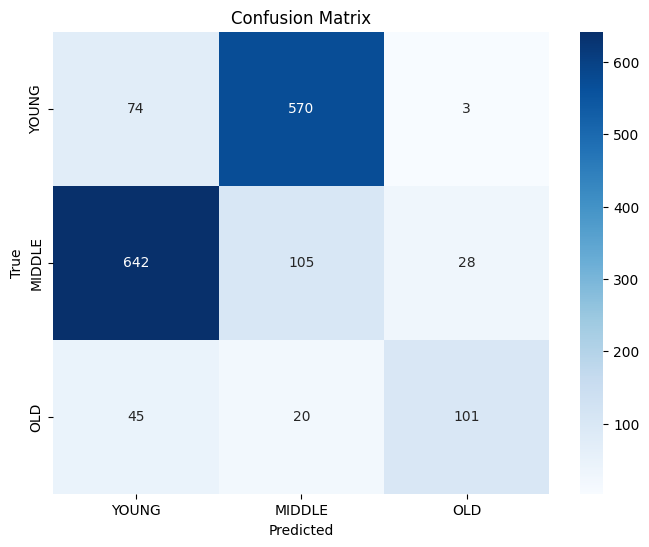

In [41]:
# **8. Test e Metriche**
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cpu"), labels.to("cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.annotations['Class'].unique()))

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
                xticklabels=test_dataset.annotations['Class'].unique(),
                yticklabels=test_dataset.annotations['Class'].unique())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Valutazione sul test set
evaluate_model(model, test_loader)

NUOVO MODELLO


In [42]:
pip install transformers datasets torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [12]:
import os
import pandas as pd
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}  # Mappiamo le etichette in numeri

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]  # Prima colonna: Nome immagine
        label = self.annotations.iloc[idx, 1]  # Seconda colonna: Classe

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")  # Carichiamo l'immagine

        if self.transform:
            image = self.transform(image)  # Applichiamo le trasformazioni

        # Convertiamo l'etichetta in numerico
        label = self.label_map[label]
        return {"pixel_values": image, "label": label}


In [14]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Carichiamo il processore di Hugging Face
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Creiamo una trasformazione compatibile
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [15]:
# Directory dataset
data_dir = "dataset"
splits = ["train", "validation", "test"]

# Creazione dataset e DataLoader
train_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "train", "annotations_train.csv"),
    img_dir=os.path.join(data_dir, "train"),
    transform=transform,
)

val_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "validation", "annotations_validation.csv"),
    img_dir=os.path.join(data_dir, "validation"),
    transform=transform,
)

test_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "test", "annotations_test.csv"),
    img_dir=os.path.join(data_dir, "test"),
    transform=transform,
)


In [16]:
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=3  # Numero di classi: YOUNG, MIDDLE, OLD
)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,  # Modifica in base al tempo disponibile
    learning_rate=2e-5,
    load_best_model_at_end=True,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Definiamo il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
)


<ipython-input-18-2b8844a306c2>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [23]:
import os
import pandas as pd
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Disabilitiamo Weights & Biases (W&B)
os.environ["WANDB_MODE"] = "disabled"

# Dataset personalizzato
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}

    def __len__(self):
        return int(len(self.annotations) * 0.2)  # Riduciamo al 20% del dataset

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.label_map[label]
        return {"pixel_values": image, "label": label}

# Preprocessamento
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")  # Modello corretto
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

# Dataset
data_dir = "dataset"
train_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "train", "annotations_train.csv"),
    img_dir=os.path.join(data_dir, "train"),
    transform=transform,
)

val_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "validation", "annotations_validation.csv"),
    img_dir=os.path.join(data_dir, "validation"),
    transform=transform,
)

test_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "test", "annotations_test.csv"),
    img_dir=os.path.join(data_dir, "test"),
    transform=transform,
)

# Modello
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",  # Modello corretto e pubblico
    num_labels=3,  # Specifica il numero di classi
    ignore_mismatched_sizes=True  # Ignora il mismatch tra il layer pre-addestrato e il nuovo task
)

# Parametri di addestramento ottimizzati
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    per_device_train_batch_size=32,  # Aumentiamo il batch size
    per_device_eval_batch_size=32,
    num_train_epochs=1,  # Riduciamo a una sola epoca
    learning_rate=5e-5,
    load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
)

# Addestramento
trainer.train()

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-in

Epoch,Training Loss,Validation Loss
1,0.484800,0.482479


ValueError: Found input variables with inconsistent numbers of samples: [1588, 317]

              precision    recall  f1-score   support

       YOUNG       0.84      0.87      0.86       132
      MIDDLE       0.82      0.87      0.84       153
         OLD       0.94      0.50      0.65        32

    accuracy                           0.83       317
   macro avg       0.87      0.75      0.78       317
weighted avg       0.84      0.83      0.83       317



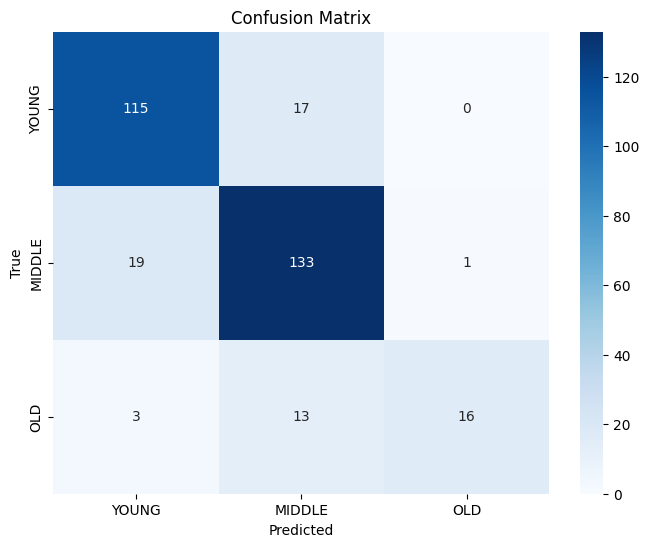

In [24]:
# Ottieni le predizioni e le etichette corrispondenti
predictions = trainer.predict(test_dataset)

# Predizioni
y_pred = predictions.predictions.argmax(axis=1)

# Etichette vere corrispondenti alle predizioni
y_true = predictions.label_ids

# Stampa il report di classificazione
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=["YOUNG", "MIDDLE", "OLD"]))

# Matrice di confusione
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=["YOUNG", "MIDDLE", "OLD"],
            yticklabels=["YOUNG", "MIDDLE", "OLD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [25]:
from google.colab import drive
import os

# Monta Google Drive
drive.mount('/content/drive')

# Specifica la directory di destinazione
model_save_path = "/content/drive/My Drive/trained_model"
os.makedirs(model_save_path, exist_ok=True)

# Salva il modello addestrato e il processore
model.save_pretrained(model_save_path)
image_processor.save_pretrained(model_save_path)

print(f"Modello salvato con successo in: {model_save_path}")


Mounted at /content/drive
Modello salvato con successo in: /content/drive/My Drive/trained_model
